# Binned fit with hist PDF

In [1]:
import os
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
from lib.params import mdn

In [3]:
data_path = './mcsamples'

In [4]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd[mask], 0, None) * mdn * 10**3)
    return np.column_stack([e[mask], pd, np.sqrt(md1pisq[mask])])

In [5]:
def smeared_sample(gsre, gsim, chunks, N=-1, silent=True):
    fname = os.path.join(data_path, f'mc_ddpip_3d_gs{gsre:.2f}_{gsim:.2f}_ch{chunks}_smeared.npy')
    if not silent:
        print(fname)
    return get_vars(np.load(fname)[:N]) if os.path.isfile(fname) else None

In [6]:
def binned_smeared_sample(gsre, gsim, chunks, bins, rng, N=-1):
    smpl = smeared_sample(gsre, gsim, chunks, N)
    if smpl is None:
        return None
    return np.histogramdd(smpl, bins=bins, range=edges)[0]

In [7]:
def make_reference(gsre, gsim, bins, rng):
    hist = binned_smeared_sample(gsre, gsim, chunks=250, bins=bins, rng=rng)
    if hist is None:
        return None
    return hist / np.sum(hist)

In [8]:
gsre0, gsim0, chunks0 = 41, 1.5, 50
test_sample = smeared_sample(gsre0, gsim0, chunks0)
test_sample.shape

(61894, 3)

In [9]:
test_sample[:5]

array([[-1.8318750e-01,  3.9051517e+01,  2.0085833e+00],
       [ 5.6085639e-02,  4.4605392e+01,  2.0094507e+00],
       [ 2.0143719e+00,  8.3349091e+01,  2.0103295e+00],
       [ 4.0795660e+00,  6.2979267e+01,  2.0127962e+00],
       [ 2.4006266e-02,  2.5311789e+01,  2.0091407e+00]], dtype=float32)

In [10]:
def draw_1d_projections(ax, data, bins, rng, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for i in range(3):
        ax[i].hist(data[:,i], bins=bins[i], range=rng[i], weights=weights)
        ax[i].set_xlim(rng[i])
        ax[i].grid()
        ax[i].set_xlabel(labels[i])

In [11]:
bins = (60,30,30)
edges = ((-2.5, 8.), (0, 120), (2.004, 2.016))

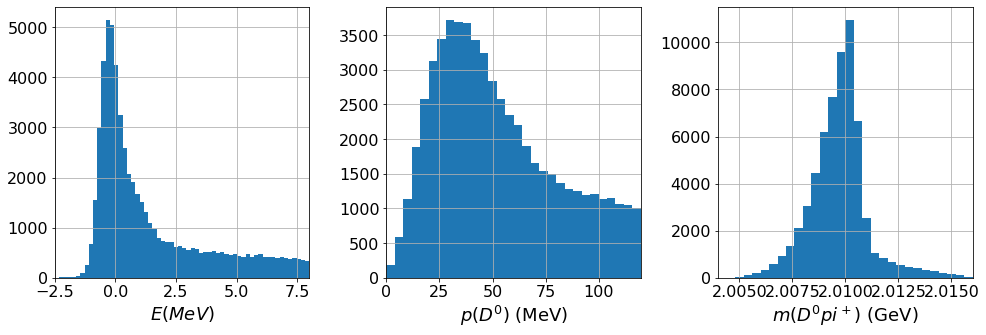

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(14,5))
draw_1d_projections(ax, test_sample, bins=bins, rng=edges)
fig.tight_layout()

In [13]:
sample = binned_smeared_sample(gsre0, gsim0, chunks0, bins, edges, N=5*10**4)

In [14]:
sample.shape

(60, 30, 30)

In [15]:
np.sum(sample)

45668.0

Most bins are empty

In [16]:
np.sum(sample==0), np.sum(sample!=0)

(46318, 7682)

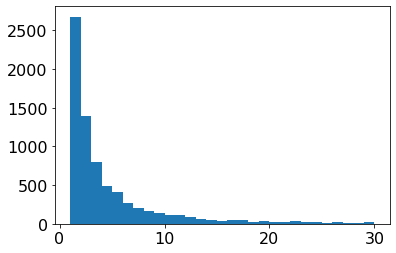

In [17]:
plt.hist(sample.flatten(), bins=29, range=(1, 30));

Chi2 fit cannot be used since most of bins contain zero or only a few events. Let't construct the binned likelihood function

$$
{\cal L} = \prod_i \frac{\mu_i^{n_i}e^{-\mu_i}}{n_i!}
$$

$$
{\cal F} = -\ln{\cal L}=-\sum_i\left(n_i\ln \mu_i - \mu_i - \ln (n_i!)\right)
$$

Second term in sum gives number of events in a tested sample $N$. The last term doesn't independ on the test sample, but we keep it in order to compare different reference probability densities.

$$
{\cal F} = -\sum_i\left(n_i\ln \mu_i - \ln (n_i!)\right) + N
$$

In [32]:
def binned_loglh(hist, ref_hist):
    """ Binned log likelihood function """
    mask = ref_hist > 0
    n = hist[mask].astype(np.int64)
    N = np.sum(n)
    mu = ref_hist[mask] / np.sum(ref_hist) * N
#     return -np.sum(n * np.log(mu)) + N
    fact = np.array(list(map(np.math.factorial, n))).astype(np.float64)
    return -np.sum(n * np.log(mu) - np.log(fact)) + N

In [33]:
gsrel = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
gsiml = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]

In [34]:
mg_gsre, mg_gsim = np.meshgrid(gsrel, gsiml)
mg_gsre.shape

(9, 12)

In [35]:
def make_lhmap(samp, gsre, gsim, bins, rng, subtract_min=True):
    """ """
    lhmap = np.empty(gsre.shape)
    for i in range(lhmap.shape[0]):
        for j in range(lhmap.shape[1]):
            reference = make_reference(gsre[i,j], gsim[i,j], bins, rng)
            if reference is None:
                print(f'reference not found for {mg_gsre[i,j]} {mg_gsim[i,j]}')
                lhmap[i,j] = -1
                continue
            lhmap[i,j] = binned_loglh(samp, reference)
    if subtract_min:
        lhmap -= np.min(lhmap)
    return lhmap

In [41]:
lhmap = make_lhmap(sample, mg_gsre, mg_gsim, bins, edges, subtract_min=True)

In [42]:
def draw_spline_contours(ax, x, y, z, levels=10):
#     f = interpolate.interp2d(x, y, z, kind='cubic')
    f = interpolate.interp2d(x, y, z, kind='linear')
    newx = np.linspace(np.min(x), np.max(x), 50)
    newy = np.linspace(np.min(y), np.max(y), 50)
    cntf = ax.contourf(newx, newy, f(newx, newy), levels=levels);
    plt.colorbar(cntf, ax=ax);

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=13,12 m=108 fp=13792.914875 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


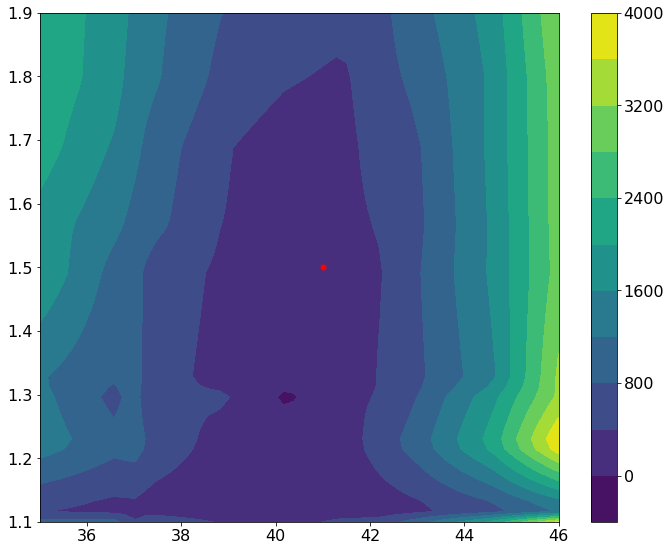

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
draw_spline_contours(ax, mg_gsre, mg_gsim, lhmap, levels=10)
ax.plot([41], [1.5], marker='.', markersize=10, color='r');
fig.tight_layout()

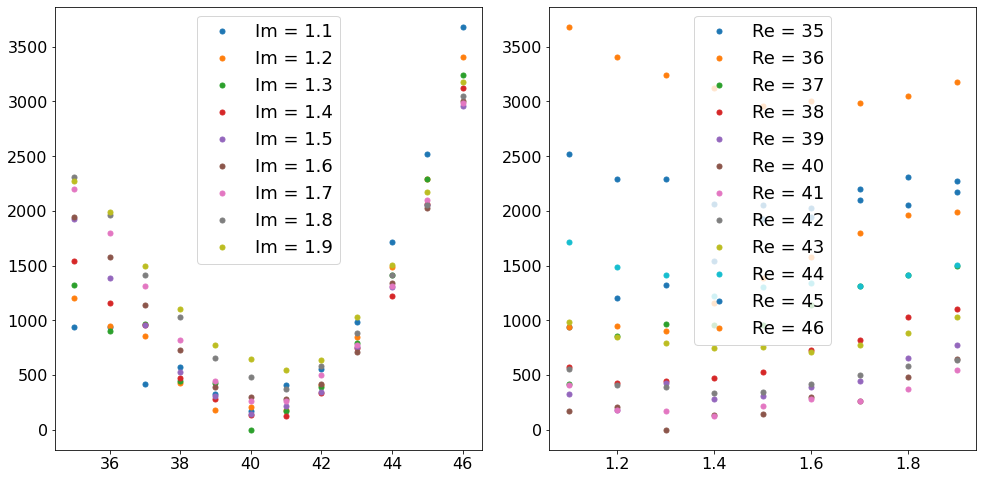

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
for i in range(lhmap.shape[0]):
    ax[0].plot(gsrel, lhmap[i,:], linestyle='none', marker='.', markersize=10, label=f'Im = {gsiml[i]}')
    ax[0].legend()

for j in range(lhmap.shape[1]):
    ax[1].plot(gsiml, lhmap[:,j], linestyle='none', marker='.', markersize=10, label=f'Re = {gsrel[j]}');
    ax[1].legend()

fig.tight_layout()